# Vector-space models: dimensionality reduction

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2021"

In [66]:
x = np.random.randint(-100,100,10000)
y = np.random.randint(-100,100,10000)
df = pd.DataFrame(zip(x,y),columns=['x','y'])

<AxesSubplot:xlabel='x', ylabel='y'>

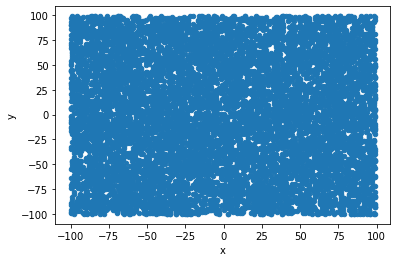

In [67]:
df.plot.scatter('x','y')

In [68]:
df_normed = df.apply(vsm.length_norm, axis=1)

<AxesSubplot:xlabel='x', ylabel='y'>

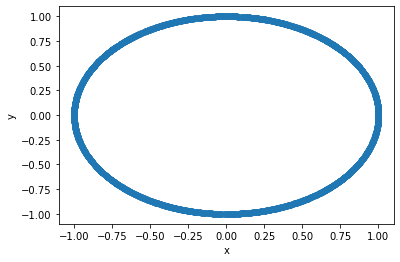

In [69]:
df_normed.plot.scatter('x', 'y')

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Latent Semantic Analysis](#Latent-Semantic-Analysis)
  1. [Overview of the LSA method](#Overview-of-the-LSA-method)
  1. [Motivating example for LSA](#Motivating-example-for-LSA)
  1. [Applying LSA to real VSMs](#Applying-LSA-to-real-VSMs)
  1. [Other resources for matrix factorization](#Other-resources-for-matrix-factorization)
1. [GloVe](#GloVe)
  1. [Overview of the GloVe method](#Overview-of-the-GloVe-method)
  1. [GloVe implementation notes](#GloVe-implementation-notes)
  1. [Applying GloVe to our motivating example](#Applying-GloVe-to-our-motivating-example)
  1. [Testing the GloVe implementation](#Testing-the-GloVe-implementation)
  1. [Applying GloVe to real VSMs](#Applying-GloVe-to-real-VSMs)
1. [Autoencoders](#Autoencoders)
  1. [Overview of the autoencoder method](#Overview-of-the-autoencoder-method)
  1. [Testing the autoencoder implementation](#Testing-the-autoencoder-implementation)
  1. [Applying autoencoders to real VSMs](#Applying-autoencoders-to-real-VSMs)
1. [Other methods](#Other-methods)

## Overview

The matrix weighting schemes reviewed in the first notebook for this unit deliver solid results. However, they are not capable of capturing higher-order associations in the data. 

With dimensionality reduction, the goal is to eliminate correlations in the input VSM and capture such higher-order notions of co-occurrence, thereby improving the overall space.

As a motivating example, consider the adjectives _gnarly_ and _wicked_ used as slang positive adjectives.  Since both are positive, we expect them to be similar in a good VSM. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely to occur often in the same texts, and so the methods we've reviewed so far will not be able to model their similarity. 

Dimensionality reduction techniques are often capable of capturing such semantic similarities (and have the added advantage of shrinking the size of our data structures).

## Set-up

* Make sure your environment meets all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u/). For help getting set-up, see [setup.ipynb](setup.ipynb).

* Make sure you've downloaded [the data distribution for this course](http://web.stanford.edu/class/cs224u/data/data.tgz), unpacked it, and placed it in the current directory (or wherever you point `DATA_HOME` to below).

In [70]:
from torch_glove import TorchGloVe
import numpy as np
from np_glove import GloVe
import os
import pandas as pd
import scipy.stats
from torch_autoencoder import TorchAutoencoder
import utils
import vsm

In [71]:
# Set all the random seeds for reproducibility:

utils.fix_random_seeds()

In [72]:
DATA_HOME = os.path.join('data', 'vsmdata')

In [73]:
yelp5 = pd.read_csv(
    os.path.join(DATA_HOME, 'yelp_window5-scaled.csv.gz'), index_col=0)

In [74]:
yelp20 = pd.read_csv(
    os.path.join(DATA_HOME, 'yelp_window20-flat.csv.gz'), index_col=0)

In [75]:
giga5 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window5-scaled.csv.gz'), index_col=0)

In [76]:
giga20 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

## Latent Semantic Analysis

Latent Semantic Analysis (LSA) is a prominent dimensionality reduction technique. It is an application of __truncated singular value decomposition__ (SVD) and so uses only techniques from linear algebra (no machine learning needed).

### Overview of the LSA method

The central mathematical result is that, for any matrix of real numbers $X$ of dimension $m \times n$, there is a factorization of $X$ into matrices $T$, $S$, and $D$ such that

$$X_{m \times n} = T_{m \times m}S_{m\times m}D_{n \times m}^{\top}$$

The matrices $T$ and $D$ are  __orthonormal__ – their columns are length-normalized and orthogonal to one another (that is, they each have cosine distance of $1$ from each other). The singular-value matrix $S$ is a diagonal matrix arranged by size, so that the first dimension corresponds to the greatest source of variability in the data, followed by the second, and so on.

Of course, we don't want to factorize and rebuild the original matrix, as that wouldn't get us anywhere. The __truncation__ part means that we include only the top $k$ dimensions of $S$. Given our row-oriented perspective on these matrices, this means using

$$T[1{:}m, 1{:}k]S[1{:}k, 1{:}k]$$

which gives us a version of $T$ that includes only the top $k$ dimensions of variation. 

To build up intuitions, imagine that everyone on the Stanford campus is associated with a 3d point representing their position: $x$ is east–west, $y$ is north–south, and $z$ is zenith–nadir. Since the campus is spread out and has relatively few deep basements and tall buildings, the top two dimensions of variation will be $x$ and $y$, and the 2d truncated SVD of this space will leave $z$ out. This will, for example, capture the sense in which someone at the top of Hoover Tower is close to someone at its base.

### Motivating example for LSA

We can also return to our original motivating example of _wicked_ and _gnarly_. Here is a matrix reflecting those assumptions:

In [78]:
gnarly_df = pd.DataFrame(
    np.array([
        [1,0,1,0,0,0],
        [0,1,0,1,0,0],
        [1,1,1,1,0,0],
        [0,0,0,0,1,1],
        [0,0,0,0,0,1]], dtype='float64'),
    index=['gnarly', 'wicked', 'awesome', 'lame', 'terrible'])

gnarly_df

,0,1,2,3,4,5
gnarly,1.0,0.0,1.0,0.0,0.0,0.0
wicked,0.0,1.0,0.0,1.0,0.0,0.0
awesome,1.0,1.0,1.0,1.0,0.0,0.0
lame,0.0,0.0,0.0,0.0,1.0,1.0
terrible,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
vsm.cosine(gnarly_df.loc['gnarly'], gnarly_df.loc['wicked'])

1.0

No column context includes both _gnarly_ and _wicked_ together so our count matrix places them far apart:

In [85]:
vsm.neighbors('gnarly', gnarly_df)

gnarly      0.000000
awesome     0.292893
wicked      1.000000
lame        1.000000
terrible    1.000000
dtype: float64

Reweighting doesn't help. For example, here is the attempt with Positive PMI:

In [86]:
vsm.neighbors('gnarly', vsm.pmi(gnarly_df))

gnarly      0.000000
awesome     0.292893
wicked      1.000000
lame        1.000000
terrible    1.000000
dtype: float64

However, both words tend to occur with _awesome_ and not with _lame_ or _terrible_, so there is an important sense in which they are similar. LSA to the rescue:

In [87]:
gnarly_lsa_df = vsm.lsa(gnarly_df, k=2)

In [88]:
vsm.neighbors('gnarly', gnarly_lsa_df)

gnarly      0.0
wicked      0.0
awesome     0.0
lame        1.0
terrible    1.0
dtype: float64

### Applying LSA to real VSMs

Here's an example that begins to convey the effect that this can have empirically.

First, the original count matrix:

In [89]:
vsm.neighbors('superb', yelp5).head()

superb         0.000000
phenomenal     0.012159
outstanding    0.012170
fantastic      0.015080
terrific       0.016488
dtype: float64

And then LSA with $k=100$:

In [90]:
yelp5_svd = vsm.lsa(yelp5, k=100)

In [91]:
vsm.neighbors('superb', yelp5_svd).head()

superb         0.000000
outstanding    0.009402
phenomenal     0.009575
fantastic      0.012573
terrific       0.014234
dtype: float64

A common pattern in the literature is to apply PMI first. The PMI values tend to give the count matrix a normal (Gaussian) distribution that better satisfies the assumptions underlying SVD:

In [17]:
yelp5_pmi = vsm.pmi(yelp5, positive=False)

In [18]:
yelp5_pmi_svd = vsm.lsa(yelp5_pmi, k=100)

In [19]:
vsm.neighbors('superb', yelp5_pmi_svd).head()

superb         0.000000
phenomenal     0.040337
outstanding    0.066857
terrific       0.068770
exceptional    0.077025
dtype: float64

### Other resources for matrix factorization

The [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) module contains an implementation of LSA ([TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)) that you might want to switch to for real experiments:

* The `sklearn` version is more flexible than the above in that it can operate on both dense matrices (Numpy arrays) and sparse matrices (from Scipy).

* The `sklearn` version will make it easy to try out other dimensionality reduction methods in your own code; [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) and [Non-Negative Matrix Factorization (NMF)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF) are closely related methods that are worth a look.

## GloVe

### Overview of the GloVe method

[Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf) introduce an objective function for semantic word representations. Roughly speaking, the objective is to learn vectors for words $w_{i}$ and $w_{j}$ such that their dot product is proportional to their probability of co-occurrence:

$$w_{i}^{\top}\widetilde{w}_{k} + b_{i} + \widetilde{b}_{k} = \log(X_{ik})$$

The paper is exceptionally good at motivating this objective from first principles. In their equation (6), they define 

$$w_{i}^{\top}\widetilde{w}_{k} = \log(P_{ik}) = \log(X_{ik}) - \log(X_{i})$$

If we allow that the rows and columns can be different, then we would do

$$w_{i}^{\top}\widetilde{w}_{k} = \log(P_{ik}) = \log(X_{ik}) - \log(X_{i} \cdot X_{*k})$$

where, as in the paper, $X_{i}$ is the sum of the values in row $i$, and $X_{*k}$ is the sum of the values in column $k$.

The rightmost expression is PMI by the equivalence $\log(\frac{x}{y}) = \log(x) - \log(y)$, and hence we can see GloVe as aiming to make the dot product of two learned vectors equal to the PMI!

The full model is a weighting of this objective:

$$\sum_{i, j=1}^{|V|} f\left(X_{ij}\right)
  \left(w_i^\top \widetilde{w}_j + b_i + \widetilde{b}_j - \log X_{ij}\right)^2$$

where $V$ is the vocabulary and $f$ is a scaling factor designed to diminish the impact of very large co-occurrence counts:

$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$

Typically, $\alpha$ is set to $0.75$ and $x_{\max}$ to $100$ (though it is worth assessing how many of your non-zero counts are above this; in dense word $\times$ word matrices, you could be flattening more than you want to).

### GloVe implementation notes

* The implementation in `np_glove.GloVe` is the most stripped-down, bare-bones version of the GloVe method I could think of. As such, it is quite slow. 

* `torch_glove.py` includes a vectorized implementation that is much, much faster, so we'll mainly use that. It is based on the method and implementation introduced in [Dingwall and Potts 2018](https://www.aclweb.org/anthology/N18-2034/).

* For really large jobs, [the official C implementation released by the GloVe team](http://nlp.stanford.edu/projects/glove/) is probably the best choice.

### Applying GloVe to our motivating example

GloVe should do well on our _gnarly/wicked_ evaluation, though you will see a lot variation due to the small size of this VSM:

In [133]:
gnarly_glove_mod = GloVe(n=2, max_iter=1000)

In [134]:
gnarly_glove = gnarly_glove_mod.fit(gnarly_df)

Finished epoch 999 of 1000; error is 4.086529378429895e-055

In [135]:
vsm.neighbors('gnarly', gnarly_glove)

gnarly      0.000000
terrible    0.198219
wicked      0.218418
lame        1.458974
awesome     1.706381
dtype: float64

### Testing the GloVe implementation

It is not easy analyze GloVe values derived from real data, but the following little simulation suggests that `np_glove.glove` is working as advertised: it does seem to reliably deliver vectors whose dot products are proportional to the log co-occurrence probability:

In [136]:
glove_test_count_df = pd.DataFrame(
    np.array([
        [10.0,  2.0,  3.0,  4.0],
        [ 2.0, 10.0,  4.0,  1.0],
        [ 3.0,  4.0, 10.0,  2.0],
        [ 4.0,  1.0,  2.0, 10.0]]),
    index=['A', 'B', 'C', 'D'],
    columns=['A', 'B', 'C', 'D'])

In [137]:
glove_test_mod = GloVe(n=4, max_iter=1000)

In [138]:
glove_test_df = glove_test_mod.fit(glove_test_count_df)

Converged on iteration 898 with error 9.985611243598329e-06

The `score` method for `GloVe` performs the correlation test that seems appropriate for GloVe. We can roughly summarize the test as follows: calculate the Pearson correlation of `G.dot(G.T)` and `log P(X)`, where `G` is the learned GloVe embedding and `log P(X)` gives the log probabilities. The test exempts `0` count cells when calculating the correlation.

In [139]:
glove_test_mod.score(glove_test_count_df)

0.9682254364056933

### Applying GloVe to real VSMs

The `vsm.glove` implementation is too slow to use on real matrices. The version in the `torch_glove` module is significantly faster, making its use possible even without a GPU (and it will be very fast indeed on a GPU machine):

In [140]:
glove_model = TorchGloVe(max_iter=100)

yelp5_glv = glove_model.fit(yelp5)

Finished epoch 100 of 100; error is 1671751.015625

We can again use the `score` method to see how we did:

In [141]:
glove_model.score(yelp5)

0.3310052540077655

In [142]:
vsm.neighbors('superb', yelp5_glv).head()

superb    0.000000
stock     0.004879
famous    0.004932
posted    0.005239
wonder    0.005317
dtype: float64

## Autoencoders

An autoencoder is a machine learning model that seeks to learn parameters that predict its own input. This is meaningful when there are intermediate representations that have lower dimensionality than the inputs. These provide a reduced-dimensional view of the data akin to those learned by LSA, but now we have a lot more design choices and a lot more potential to learn higher-order associations in the underyling data.

### Overview of the autoencoder method

The module `torch_autoencoder` uses PyToch to implement a simple one-layer autoencoder:

$$
\begin{align}
h &= \mathbf{f}(xW + b_{h}) \\
\widehat{x} &= hW^{\top} + b_{x}
\end{align}$$

Here, we assume that the hidden representation $h$ has a low dimensionality like 100, and that $\mathbf{f}$ is a non-linear activation function (the default for `TorchAutoencoder` is `tanh`). These are the major design choices internal to the network. It might also be meaningful to assume that there are two matrices of weights $W_{xh}$ and $W_{hx}$, rather than using $W^{\top}$ for the output step.

The objective function for autoencoders will implement some kind of assessment of the distance between the inputs and their predicted outputs. For example, one could use the one-half mean squared error:

$$\frac{1}{m}\sum_{i=1}^{m} \frac{1}{2}(\widehat{X[i]} - X[i])^{2}$$

where $X$ is the input matrix of examples (dimension $m \times n$) and $X[i]$ corresponds to the $i$th example.

When you call the `fit` method of `TorchAutoencoder`, it returns the matrix of hidden representations $h$, which is the new embedding space: same row count as the input, but with the column count set by the `hidden_dim` parameter.

For much more on autoencoders, see the 'Autoencoders' chapter of [Goodfellow et al. 2016](http://www.deeplearningbook.org).

### Testing the autoencoder implementation

Here's an evaluation that is meant to test the autoencoder implementation – we expect it to be able to full encode the input matrix because we know its rank is equal to the dimensionality of the hidden representation.

In [143]:
def randmatrix(m, n, sigma=0.1, mu=0):
    return sigma * np.random.randn(m, n) + mu

def autoencoder_evaluation(nrow=1000, ncol=100, rank=20, max_iter=20000):
    """This an evaluation in which `TorchAutoencoder` should be able
    to perfectly reconstruct the input data, because the
    hidden representations have the same dimensionality as
    the rank of the input matrix.
    """
    X = randmatrix(nrow, rank).dot(randmatrix(rank, ncol))
    ae = TorchAutoencoder(hidden_dim=rank, max_iter=max_iter)
    ae.fit(X)
    X_pred = ae.predict(X)
    mse = (0.5 * (X_pred - X)**2).mean()
    return(X, X_pred, mse)

In [144]:
ae_max_iter = 100

_, _, ae = autoencoder_evaluation(max_iter=ae_max_iter)

print("Autoencoder evaluation MSE after {0} evaluations: {1:0.04f}".format(
    ae_max_iter, ae))

Finished epoch 100 of 100; error is 0.001447509159334004

Autoencoder evaluation MSE after 100 evaluations: 0.0007


### Applying autoencoders to real VSMs

You can apply the autoencoder directly to the count matrix, but this could interact very badly with the internal activation function: if the counts are all very high or very low, then everything might get pushed irrevocably towards the extreme values of the activation.

Thus, it's a good idea to first normalize the values somehow. Here, I use `vsm.length_norm`:

In [145]:
yelp5_l2 = yelp5.apply(vsm.length_norm, axis=1)

In [146]:
yelp5_l2_ae = TorchAutoencoder(
    max_iter=100, hidden_dim=50, eta=0.001).fit(yelp5_l2)

Stopping after epoch 28. Training loss did not improve more than tol=1e-05. Final error is 0.0003682273963931948.

In [147]:
vsm.neighbors('superb', yelp5_l2_ae).head()

superb         0.000000
outstanding    0.000018
fantastic      0.000034
terrific       0.000045
exceptional    0.000050
dtype: float64

This is very slow and often seems not to work all that well. To speed things up, one can first apply LSA or similar:

In [148]:
yelp5_l2_svd100 = vsm.lsa(yelp5_l2, k=100)

In [149]:
yelp_l2_svd100_ae = TorchAutoencoder(
    max_iter=1000, hidden_dim=50, eta=0.01).fit(yelp5_l2_svd100)

Stopping after epoch 54. Training loss did not improve more than tol=1e-05. Final error is 0.0014669671218143776.

In [150]:
vsm.neighbors('superb', yelp_l2_svd100_ae).head()

superb         0.000000
phenomenal     0.017522
fantastic      0.020830
terrific       0.025040
outstanding    0.030703
dtype: float64

## Other methods

Learning word representations is one of the most active areas in NLP right now, so I can't hope to offer a comprehensive summary. I'll settle instead for identifying some overall trends and methods:

* The label __word2vec__ picks out a family of models in which the embedding for a word $w$ is trained to predict the words that co-occur with $w$. This intuition can be cashed out in numerous ways. The skip-gram model, due to [Mikolov et al. 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality), is arguably the closest to the models discussed above. For instance, see [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) for a proof that the skip-gram model's objective reduces to PMI shifted by a constant value.

* The LexVec model of [Salle et al. 2016](https://www.aclweb.org/anthology/P16-2068/) combines the core insight of GloVe (learn vectors that approximate PMI) with the insight from word2vec that we should additionally try to push words that don't appear together farther apart in the VSM. (GloVe simply ignores 0 count cells and so can't do this.)

* Many apparently diverse models can be expressed as matrix factorization methods like SVD/LSA. See especially 
[Singh and Gordon 2008](http://www.cs.cmu.edu/~ggordon/singh-gordon-unified-factorization-ecml.pdf),
[Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization), [Cotterell et al. 2017](https://www.aclweb.org/anthology/E17-2028/).

* Subword modeling ([reviewed briefly in the previous notebook](vsm_01_distributional.ipynb#Subword-information)) is increasingly yielding dividends. (It would already be central if most of NLP focused on languages with complex morphology!) Check out the papers at the Subword and Character-Level Models for NLP Workshops: [SCLeM 2017](https://sites.google.com/view/sclem2017/home), [SCLeM 2018](https://sites.google.com/view/sclem2018/home).

* Contextualized word representations have proven valuable in many contexts. These methods do not provide representations for individual words, but rather represent them in their linguistic context. This creates space for modeling how word senses vary depending on their context of use. See [vsm_04_contextualreps.ipynb](vsm_04_contextualreps.ipynb) for techniques for using such models to create VSMs like those explored above.